# Step 0: Importing Libraries

In [1]:
import os
import zipfile
import pathlib
import shutil
import tensorflow as tf
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# Step 1: Set up Kaggle API

In [2]:
print("Please upload your kaggle.json file")
uploaded = files.upload()

if uploaded:
    uploaded_filename = list(uploaded.keys())[0]
    os.makedirs("/root/.kaggle", exist_ok=True)
    shutil.move(uploaded_filename, "/root/.kaggle/kaggle.json")
    os.chmod("/root/.kaggle/kaggle.json", 600)
    print("✅ Kaggle API key configured.")
else:
    print("❌ No file was uploaded.")

Please upload your kaggle.json file


Saving kaggle.json to kaggle.json
✅ Kaggle API key configured.


# Step 2: Download and Extract Dataset

In [3]:
print("\nDownloading dataset...")
# Note: The 'y' command is piped to the input to auto-accept the download.
!echo 'y' | kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset -p /content/dataset

zip_path = '/content/dataset/microsoft-catsvsdogs-dataset.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')
print("Dataset extracted!")


Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
 98% 771M/788M [00:03<00:00, 264MB/s]
100% 788M/788M [00:03<00:00, 231MB/s]
Dataset extracted!


# Step 3: Organize Files into Train/Validation Sets

In [4]:
print("\nOrganizing files...")
original_train_dir = pathlib.Path("/content/dataset/PetImages")
new_base_dir = pathlib.Path("/content/dataset/organized")

train_dir = new_base_dir / "train"
validation_dir = new_base_dir / "validation"
train_cats_dir = train_dir / "cats"
train_dogs_dir = train_dir / "dogs"
validation_cats_dir = validation_dir / "cats"
validation_dogs_dir = validation_dir / "dogs"

for dir_path in [train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir]:
    os.makedirs(dir_path, exist_ok=True)

cat_dir = original_train_dir / "Cat"
dog_dir = original_train_dir / "Dog"

cat_fnames = [f for f in os.listdir(cat_dir) if f.endswith(".jpg")]
dog_fnames = [f for f in os.listdir(dog_dir) if f.endswith(".jpg")]

for i, fname in enumerate(cat_fnames):
    src = cat_dir / fname
    dst = validation_cats_dir / fname if i < 1000 else train_cats_dir / fname
    shutil.copyfile(src, dst)

for i, fname in enumerate(dog_fnames):
    src = dog_dir / fname
    dst = validation_dogs_dir / fname if i < 1000 else train_dogs_dir / fname
    shutil.copyfile(src, dst)
print("File organization complete.")


Organizing files...
File organization complete.


# Step 4: Clean Corrupted & Non-Image Files (Robust Version)

In [5]:
dirs_to_check = [train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir]
num_bad_files = 0

print("\nStarting robust check for bad image files...")
for dir_path in dirs_to_check:
    for filename in os.listdir(dir_path):
        filepath = os.path.join(dir_path, filename)
        try:
            img_bytes = tf.io.read_file(filepath)
            decoded_img = tf.io.decode_image(img_bytes)
        except tf.errors.InvalidArgumentError:
            print(f"Found bad file (cannot be decoded by TF): {filepath}, removing it.")
            os.remove(filepath)
            num_bad_files += 1
print(f"Finished. Removed {num_bad_files} bad files.")


Starting robust check for bad image files...
Found bad file (cannot be decoded by TF): /content/dataset/organized/train/cats/10404.jpg, removing it.
Found bad file (cannot be decoded by TF): /content/dataset/organized/train/cats/4351.jpg, removing it.
Found bad file (cannot be decoded by TF): /content/dataset/organized/train/cats/666.jpg, removing it.
Found bad file (cannot be decoded by TF): /content/dataset/organized/train/dogs/2494.jpg, removing it.
Found bad file (cannot be decoded by TF): /content/dataset/organized/train/dogs/11912.jpg, removing it.
Found bad file (cannot be decoded by TF): /content/dataset/organized/train/dogs/11702.jpg, removing it.
Found bad file (cannot be decoded by TF): /content/dataset/organized/train/dogs/2317.jpg, removing it.
Found bad file (cannot be decoded by TF): /content/dataset/organized/train/dogs/11233.jpg, removing it.
Found bad file (cannot be decoded by TF): /content/dataset/organized/train/dogs/9500.jpg, removing it.
Finished. Removed 9 bad 

# Step 5: Create TensorFlow Datasets

In [6]:
print("\nCreating TensorFlow datasets...")
img_size = (128, 128)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary",
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary",
    seed=123
)
print("Datasets created.")


Creating TensorFlow datasets...
Found 22991 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Datasets created.


# Step 6: Configure Data Pipeline for Performance

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

AUTOTUNE = tf.data.AUTOTUNE

def normalize(img, label):
    return tf.cast(img, tf.float32) / 255.0, label

train_ds = (train_ds
    .map(normalize, num_parallel_calls=AUTOTUNE)
    .cache()
    .map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE)
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (val_ds
    .map(normalize, num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
print("Data pipeline configured for performance.")

Data pipeline configured for performance.


# Step 7: Build the CNN Model

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
print("\nModel built. Summary:")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Model built. Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

# Step 8: Compile and Train the Model

In [9]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nStarting model training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)
print("Model training complete.")


Starting model training...
Epoch 1/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 100s 130ms/step - accuracy: 0.5793 - loss: 0.6747 - val_accuracy: 0.6690 - val_loss: 0.6048
Epoch 2/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 111s 93ms/step - accuracy: 0.6986 - loss: 0.5841 - val_accuracy: 0.7120 - val_loss: 0.5455
Epoch 3/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 71s 98ms/step - accuracy: 0.7364 - loss: 0.5256 - val_accuracy: 0.7235 - val_loss: 0.5457
Epoch 4/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 68s 95ms/step - accuracy: 0.7722 - loss: 0.4757 - val_accuracy: 0.7560 - val_loss: 0.4623
Epoch 5/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 80s 92ms/step - accuracy: 0.7897 - loss: 0.4420 - val_accuracy: 0.7755 - val_loss: 0.4694
Epoch 6/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 85s 96ms/step - accuracy: 0.8118 - loss: 0.4141 - val_accuracy: 0.7825 - val_loss: 0.4625
Epoch 7/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 80s 94ms/step - accuracy: 0.8192 - loss: 0.3978 - val_accuracy: 0.8195 - val_loss: 0.3814
Epoch 8/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 82s 94ms/step - acc

# Step 9: Visualize Training Results


Plotting training history...


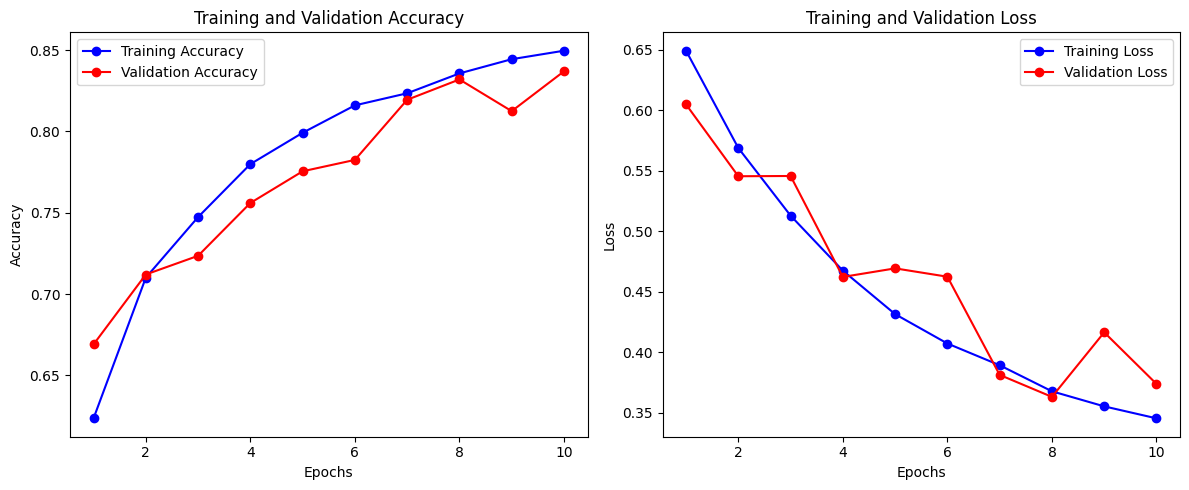

In [10]:
print("\nPlotting training history...")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Step 10: Save the Trained Model

In [11]:
print("\nSaving the trained model...")

# Save the model to a single file in the recommended .keras format
model.save('cats_vs_dogs_model.keras')

print("Model saved successfully as cats_vs_dogs_model.keras")

# You can later load the model back using this command:
# from tensorflow import keras
# loaded_model = keras.models.load_model('cats_vs_dogs_model.keras')
# print("Model loaded successfully.")


Saving the trained model...
Model saved successfully as cats_vs_dogs_model.keras
